In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
# Import des bibliothèques nécessaires
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Chargement des données
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Étape 1 : Création de nouvelles fonctionnalités
# Ajout de 'FamilySize'
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Extraction des titres
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Remplacement des titres rares par 'Rare'
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
train_df['Title'] = train_df['Title'].replace(rare_titles, 'Rare')
test_df['Title'] = test_df['Title'].replace(rare_titles, 'Rare')

# Remplacement des titres incohérents
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

# Traitement spécial pour le titre 'Dona' (supposé être une femme)
test_df.loc[test_df['Title'] == 'Dona', 'Survived'] = 1  # Imputation à 100% de survie

# Étape 2 : Remplissage des valeurs manquantes
# Remplir Age et Fare par la médiane
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
test_df['Age'].fillna(test_df['Age'].median(), inplace=True)

train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)

# Remplir Embarked par le mode
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

# Étape 3 : Encodage des variables catégoriques
label_enc = LabelEncoder()

# Encodage des colonnes catégoriques : Sex, Embarked, Title
for col in ['Sex', 'Embarked', 'Title']:
    train_df[col] = label_enc.fit_transform(train_df[col])
    test_df[col] = label_enc.transform(test_df[col])

# Étape 4 : Préparation des jeux d'entraînement et de test
# Sélection des caractéristiques pertinentes pour l'entraînement
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']
X_train = train_df[features]
y_train = train_df['Survived']

X_test = test_df[features]  # Pour le fichier de soumission

# Étape 5 : Entraînement du modèle avec les hyperparamètres optimisés
rf_model = RandomForestClassifier(n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_depth=20, random_state=42)

# Validation croisée pour évaluer la performance sur le jeu d'entraînement
scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Afficher la précision moyenne
print(f"Précision moyenne pendant la validation croisée : {scores.mean() * 100:.2f}%")

# Entraîner le modèle sur l'ensemble des données d'entraînement
rf_model.fit(X_train, y_train)

# Prédictions sur les données de test
test_predictions = rf_model.predict(X_test)

# Création du fichier de soumission
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

# Sauvegarde du fichier de soumission
submission.to_csv('submission.csv', index=False)

print("Fichier submission.csv créé avec succès.")


/tmp/ipykernel_37/56860090.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
/tmp/ipykernel_37/56860090.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

Précision moyenne pendant la validation croisée : 83.73%
Fichier submission.csv créé avec succès.


In [5]:
# Fonction pour extraire les trois premiers caractères (chiffres/lettres) d'un numéro de ticket
def extract_ticket_prefix(ticket):
    ticket = str(ticket)
    return ticket[:3]

# Appliquer la fonction pour extraire les préfixes de tickets dans le dataset
train_df['Ticket_Prefix'] = train_df['Ticket'].apply(extract_ticket_prefix)

# Regrouper les données par 'Ticket_Prefix' et 'Sex' et calculer le nombre de passagers et le taux de survie
gender_prefix_summary = train_df.groupby(['Ticket_Prefix', 'Sex']).agg(
    num_passengers=('PassengerId', 'count'),
    survival_rate=('Survived', 'mean')
).reset_index()

# Convertir les codes sexe en lisible
gender_prefix_summary['Sex'] = gender_prefix_summary['Sex'].map({0: 'male', 1: 'female'})

# Vérification des taux de survie avec un affichage plus simple (inversé pour homme/femme)
for prefix in gender_prefix_summary['Ticket_Prefix'].unique():
    male_data = gender_prefix_summary[(gender_prefix_summary['Ticket_Prefix'] == prefix) & (gender_prefix_summary['Sex'] == 'female')]  # Inverser
    female_data = gender_prefix_summary[(gender_prefix_summary['Ticket_Prefix'] == prefix) & (gender_prefix_summary['Sex'] == 'male')]  # Inverser
    
    male_passengers = male_data['num_passengers'].values[0] if not male_data.empty else 0
    male_survival_rate = male_data['survival_rate'].values[0] * 100 if not male_data.empty else 0
    
    female_passengers = female_data['num_passengers'].values[0] if not female_data.empty else 0
    female_survival_rate = female_data['survival_rate'].values[0] * 100 if not female_data.empty else 0

    # Ignorer les préfixes avec moins de 2 passagers au total
    if male_passengers + female_passengers > 1:
        print(f"Prefix {prefix}: male {male_passengers} - {male_survival_rate:.2f}% / female {female_passengers} - {female_survival_rate:.2f}%")


Prefix 110: male 4 - 25.00% / female 6 - 100.00%
Prefix 111: male 6 - 66.67% / female 2 - 100.00%
Prefix 112: male 6 - 16.67% / female 1 - 100.00%
Prefix 113: male 32 - 28.12% / female 15 - 86.67%
Prefix 116: male 1 - 0.00% / female 1 - 0.00%
Prefix 117: male 5 - 80.00% / female 6 - 100.00%
Prefix 119: male 1 - 100.00% / female 1 - 100.00%
Prefix 127: male 0 - 0.00% / female 2 - 100.00%
Prefix 132: male 2 - 100.00% / female 0 - 0.00%
Prefix 135: male 3 - 33.33% / female 5 - 100.00%
Prefix 143: male 0 - 0.00% / female 3 - 100.00%
Prefix 160: male 7 - 71.43% / female 0 - 0.00%
Prefix 169: male 1 - 100.00% / female 2 - 100.00%
Prefix 174: male 5 - 60.00% / female 7 - 100.00%
Prefix 198: male 1 - 0.00% / female 1 - 100.00%
Prefix 199: male 9 - 55.56% / female 5 - 100.00%
Prefix 220: male 1 - 0.00% / female 2 - 100.00%
Prefix 226: male 0 - 0.00% / female 2 - 100.00%
Prefix 230: male 4 - 75.00% / female 4 - 100.00%
Prefix 231: male 1 - 0.00% / female 2 - 100.00%
Prefix 233: male 2 - 0.00% / 

In [6]:
# Fonction pour extraire les deux premiers caractères du numéro de ticket
def extract_ticket_prefix_2(ticket):
    ticket = str(ticket)
    return ticket[:2]

# Appliquer la fonction pour extraire les préfixes de tickets à 2 caractères dans le dataset
train_df['Ticket_Prefix_2'] = train_df['Ticket'].apply(extract_ticket_prefix_2)

# Regrouper les données par 'Ticket_Prefix_2' et 'Sex' et calculer le nombre de passagers et le taux de survie
gender_prefix_summary_2 = train_df.groupby(['Ticket_Prefix_2', 'Sex']).agg(
    num_passengers=('PassengerId', 'count'),
    survival_rate=('Survived', 'mean')
).reset_index()

# Convertir les codes sexe en lisible et inverser homme/femme
gender_prefix_summary_2['Sex'] = gender_prefix_summary_2['Sex'].map({0: 'female', 1: 'male'})

# Affichage des résultats
for prefix in gender_prefix_summary_2['Ticket_Prefix_2'].unique():
    male_data = gender_prefix_summary_2[(gender_prefix_summary_2['Ticket_Prefix_2'] == prefix) & (gender_prefix_summary_2['Sex'] == 'male')]
    female_data = gender_prefix_summary_2[(gender_prefix_summary_2['Ticket_Prefix_2'] == prefix) & (gender_prefix_summary_2['Sex'] == 'female')]
    
    male_passengers = male_data['num_passengers'].values[0] if not male_data.empty else 0
    male_survival_rate = male_data['survival_rate'].values[0] * 100 if not male_data.empty else 0
    
    female_passengers = female_data['num_passengers'].values[0] if not female_data.empty else 0
    female_survival_rate = female_data['survival_rate'].values[0] * 100 if not female_data.empty else 0

    # Ignorer les préfixes avec moins de 2 passagers
    if male_passengers + female_passengers > 1:
        print(f"Prefix {prefix}: male {male_passengers} - {male_survival_rate:.2f}% / female {female_passengers} - {female_survival_rate:.2f}%")


Prefix 11: male 55 - 36.36% / female 33 - 90.91%
Prefix 12: male 2 - 0.00% / female 2 - 100.00%
Prefix 13: male 6 - 50.00% / female 5 - 100.00%
Prefix 14: male 1 - 0.00% / female 3 - 100.00%
Prefix 16: male 8 - 75.00% / female 2 - 100.00%
Prefix 17: male 6 - 50.00% / female 7 - 100.00%
Prefix 19: male 10 - 50.00% / female 6 - 100.00%
Prefix 21: male 4 - 0.00% / female 0 - 0.00%
Prefix 22: male 3 - 0.00% / female 6 - 100.00%
Prefix 23: male 23 - 17.39% / female 13 - 92.31%
Prefix 24: male 15 - 26.67% / female 14 - 85.71%
Prefix 25: male 7 - 14.29% / female 7 - 85.71%
Prefix 26: male 36 - 25.00% / female 24 - 66.67%
Prefix 27: male 2 - 50.00% / female 2 - 100.00%
Prefix 28: male 10 - 0.00% / female 2 - 100.00%
Prefix 29: male 8 - 37.50% / female 6 - 100.00%
Prefix 31: male 27 - 7.41% / female 10 - 70.00%
Prefix 32: male 3 - 0.00% / female 0 - 0.00%
Prefix 33: male 6 - 16.67% / female 10 - 80.00%
Prefix 34: male 95 - 7.37% / female 37 - 32.43%
Prefix 35: male 20 - 15.00% / female 7 - 71.4

In [7]:
# Fonction pour extraire les quatre premiers caractères du numéro de ticket
def extract_ticket_prefix_4(ticket):
    ticket = str(ticket)
    return ticket[:4]

# Appliquer la fonction pour extraire les préfixes de tickets à 4 caractères dans le dataset
train_df['Ticket_Prefix_4'] = train_df['Ticket'].apply(extract_ticket_prefix_4)

# Regrouper les données par 'Ticket_Prefix_4' et 'Sex' et calculer le nombre de passagers et le taux de survie
gender_prefix_summary_4 = train_df.groupby(['Ticket_Prefix_4', 'Sex']).agg(
    num_passengers=('PassengerId', 'count'),
    survival_rate=('Survived', 'mean')
).reset_index()

# Convertir les codes sexe en lisible et inverser homme/femme
gender_prefix_summary_4['Sex'] = gender_prefix_summary_4['Sex'].map({0: 'female', 1: 'male'})

# Affichage des résultats
for prefix in gender_prefix_summary_4['Ticket_Prefix_4'].unique():
    male_data = gender_prefix_summary_4[(gender_prefix_summary_4['Ticket_Prefix_4'] == prefix) & (gender_prefix_summary_4['Sex'] == 'male')]
    female_data = gender_prefix_summary_4[(gender_prefix_summary_4['Ticket_Prefix_4'] == prefix) & (gender_prefix_summary_4['Sex'] == 'female')]
    
    male_passengers = male_data['num_passengers'].values[0] if not male_data.empty else 0
    male_survival_rate = male_data['survival_rate'].values[0] * 100 if not male_data.empty else 0
    
    female_passengers = female_data['num_passengers'].values[0] if not female_data.empty else 0
    female_survival_rate = female_data['survival_rate'].values[0] * 100 if not female_data.empty else 0

    # Ignorer les préfixes avec moins de 2 passagers
    if male_passengers + female_passengers > 1:
        print(f"Prefix {prefix}: male {male_passengers} - {male_survival_rate:.2f}% / female {female_passengers} - {female_survival_rate:.2f}%")


Prefix 1101: male 0 - 0.00% / female 3 - 100.00%
Prefix 1104: male 3 - 0.00% / female 2 - 100.00%
Prefix 1113: male 2 - 50.00% / female 2 - 100.00%
Prefix 1114: male 3 - 100.00% / female 0 - 0.00%
Prefix 1120: male 4 - 0.00% / female 1 - 100.00%
Prefix 1130: male 7 - 14.29% / female 0 - 0.00%
Prefix 1135: male 5 - 0.00% / female 4 - 100.00%
Prefix 1137: male 15 - 40.00% / female 9 - 77.78%
Prefix 1138: male 5 - 40.00% / female 2 - 100.00%
Prefix 1166: male 1 - 0.00% / female 1 - 0.00%
Prefix 1175: male 2 - 100.00% / female 3 - 100.00%
Prefix 1176: male 1 - 100.00% / female 3 - 100.00%
Prefix 1177: male 2 - 50.00% / female 0 - 0.00%
Prefix 1196: male 1 - 100.00% / female 1 - 100.00%
Prefix 1274: male 0 - 0.00% / female 2 - 100.00%
Prefix 1321: male 2 - 100.00% / female 0 - 0.00%
Prefix 1350: male 2 - 0.00% / female 4 - 100.00%
Prefix 1356: male 1 - 100.00% / female 1 - 100.00%
Prefix 1431: male 0 - 0.00% / female 3 - 100.00%
Prefix 1601: male 7 - 71.43% / female 0 - 0.00%
Prefix 1696: m

In [8]:
# Regrouper les données par 'Pclass' et 'Sex' et calculer le nombre de passagers et le taux de survie
gender_class_summary = train_df.groupby(['Pclass', 'Sex']).agg(
    num_passengers=('PassengerId', 'count'),
    survival_rate=('Survived', 'mean')
).reset_index()

# Convertir les codes sexe en lisible et inverser homme/femme
gender_class_summary['Sex'] = gender_class_summary['Sex'].map({0: 'female', 1: 'male'})

# Affichage des taux de survie pour les hommes et les femmes par classe
for pclass in gender_class_summary['Pclass'].unique():
    male_data = gender_class_summary[(gender_class_summary['Pclass'] == pclass) & (gender_class_summary['Sex'] == 'male')]
    female_data = gender_class_summary[(gender_class_summary['Pclass'] == pclass) & (gender_class_summary['Sex'] == 'female')]
    
    male_passengers = male_data['num_passengers'].values[0] if not male_data.empty else 0
    male_survival_rate = male_data['survival_rate'].values[0] * 100 if not male_data.empty else 0
    
    female_passengers = female_data['num_passengers'].values[0] if not female_data.empty else 0
    female_survival_rate = female_data['survival_rate'].values[0] * 100 if not female_data.empty else 0

    print(f"Class {pclass}: male {male_passengers} - {male_survival_rate:.2f}% / female {female_passengers} - {female_survival_rate:.2f}%")


Class 1: male 122 - 36.89% / female 94 - 96.81%
Class 2: male 108 - 15.74% / female 76 - 92.11%
Class 3: male 347 - 13.54% / female 144 - 50.00%


In [9]:
import pandas as pd

# Fonction pour extraire les trois premiers caractères (chiffres/lettres) d'un numéro de ticket
def extract_ticket_prefix(ticket):
    ticket = str(ticket)
    return ticket[:3]

# Appliquer la fonction pour extraire les préfixes de tickets dans le dataset
train_df['Ticket_Prefix'] = train_df['Ticket'].apply(extract_ticket_prefix)

# Regrouper les données par 'Ticket_Prefix' et 'Sex' et calculer le nombre de passagers et le taux de survie
gender_prefix_summary = train_df.groupby(['Ticket_Prefix', 'Sex']).agg(
    num_passengers=('PassengerId', 'count'),
    survival_rate=('Survived', 'mean')
).reset_index()

# Convertir les codes sexe en lisible (0 = female, 1 = male)
gender_prefix_summary['Sex'] = gender_prefix_summary['Sex'].map({0: 'female', 1: 'male'})

# Filtrer les préfixes où le taux de survie des femmes est inférieur à 60%
for prefix in gender_prefix_summary['Ticket_Prefix'].unique():
    female_data = gender_prefix_summary[(gender_prefix_summary['Ticket_Prefix'] == prefix) & (gender_prefix_summary['Sex'] == 'female')]
    
    female_passengers = female_data['num_passengers'].values[0] if not female_data.empty else 0
    female_survival_rate = female_data['survival_rate'].values[0] * 100 if not female_data.empty else 0

    # Afficher les préfixes où le taux de survie des femmes est inférieur à 60%
    if female_survival_rate < 60 and female_passengers > 0:
        print(f"Prefix {prefix}: female {female_passengers} - {female_survival_rate:.2f}%")


Prefix 116: female 1 - 0.00%
Prefix 244: female 2 - 50.00%
Prefix 262: female 2 - 50.00%
Prefix 267: female 2 - 0.00%
Prefix 268: female 2 - 50.00%
Prefix 269: female 2 - 0.00%
Prefix 315: female 3 - 33.33%
Prefix 343: female 2 - 50.00%
Prefix 345: female 5 - 20.00%
Prefix 347: female 21 - 33.33%
Prefix 349: female 8 - 25.00%
Prefix 350: female 3 - 33.33%
Prefix 364: female 6 - 33.33%
Prefix 365: female 1 - 0.00%
Prefix 382: female 2 - 0.00%
Prefix 413: female 8 - 25.00%
Prefix 754: female 1 - 0.00%
Prefix 755: female 2 - 0.00%
Prefix A/5: female 2 - 0.00%
Prefix CA : female 2 - 0.00%
Prefix CA.: female 4 - 25.00%
Prefix S.O: female 1 - 0.00%
Prefix SOT: female 1 - 0.00%
Prefix W./: female 6 - 16.67%


In [10]:
import pandas as pd

# Fonction pour extraire les trois premiers caractères (chiffres/lettres) d'un numéro de ticket
def extract_ticket_prefix(ticket):
    ticket = str(ticket)
    return ticket[:3]

# Appliquer la fonction pour extraire les préfixes de tickets dans le dataset
train_df['Ticket_Prefix'] = train_df['Ticket'].apply(extract_ticket_prefix)

# Regrouper les données par 'Ticket_Prefix' et 'Sex' et calculer le nombre de passagers et le taux de survie
gender_prefix_summary = train_df.groupby(['Ticket_Prefix', 'Sex']).agg(
    num_passengers=('PassengerId', 'count'),
    survival_rate=('Survived', 'mean')
).reset_index()

# Convertir les codes sexe en lisible (0 = female, 1 = male)
gender_prefix_summary['Sex'] = gender_prefix_summary['Sex'].map({0: 'female', 1: 'male'})

# Filtrer les préfixes où le taux de survie des hommes est supérieur à 60%
for prefix in gender_prefix_summary['Ticket_Prefix'].unique():
    male_data = gender_prefix_summary[(gender_prefix_summary['Ticket_Prefix'] == prefix) & (gender_prefix_summary['Sex'] == 'male')]
    
    male_passengers = male_data['num_passengers'].values[0] if not male_data.empty else 0
    male_survival_rate = male_data['survival_rate'].values[0] * 100 if not male_data.empty else 0

    # Afficher les préfixes où le taux de survie des hommes est supérieur à 60%
    if male_survival_rate > 60 and male_passengers > 0:
        print(f"Prefix {prefix}: male {male_passengers} - {male_survival_rate:.2f}%")


Prefix 111: male 6 - 66.67%
Prefix 117: male 5 - 80.00%
Prefix 119: male 1 - 100.00%
Prefix 132: male 2 - 100.00%
Prefix 160: male 7 - 71.43%
Prefix 169: male 1 - 100.00%
Prefix 230: male 4 - 75.00%
Prefix 265: male 3 - 66.67%
Prefix 759: male 1 - 100.00%
Prefix C 1: male 1 - 100.00%
Prefix S.W: male 1 - 100.00%
Prefix SW/: male 1 - 100.00%


In [20]:
# Fonction pour extraire le premier caractère du numéro de ticket
def extract_ticket_prefix_1(ticket):
    ticket = str(ticket)
    return ticket[:1]

# Appliquer la fonction pour extraire les préfixes de tickets à 1 caractère dans le dataset
train_df['Ticket_Prefix_1'] = train_df['Ticket'].apply(extract_ticket_prefix_1)

# Regrouper les données par 'Ticket_Prefix_1' et 'Sex' et calculer le nombre de passagers et le taux de survie
gender_prefix_summary_1 = train_df.groupby(['Ticket_Prefix_1', 'Sex']).agg(
    num_passengers=('PassengerId', 'count'),
    survival_rate=('Survived', 'mean')
).reset_index()

# Convertir les codes sexe en lisible (0 pour female, 1 pour male)
gender_prefix_summary_1['Sex'] = gender_prefix_summary_1['Sex'].map({0: 'female', 1: 'male'})

# Affichage des résultats
for prefix in gender_prefix_summary_1['Ticket_Prefix_1'].unique():
    male_data = gender_prefix_summary_1[(gender_prefix_summary_1['Ticket_Prefix_1'] == prefix) & (gender_prefix_summary_1['Sex'] == 'male')]
    female_data = gender_prefix_summary_1[(gender_prefix_summary_1['Ticket_Prefix_1'] == prefix) & (gender_prefix_summary_1['Sex'] == 'female')]
    
    male_passengers = male_data['num_passengers'].values[0] if not male_data.empty else 0
    male_survival_rate = male_data['survival_rate'].values[0] * 100 if not male_data.empty else 0
    
    female_passengers = female_data['num_passengers'].values[0] if not female_data.empty else 0
    female_survival_rate = female_data['survival_rate'].values[0] * 100 if not female_data.empty else 0

    # Ignorer les préfixes avec moins de 2 passagers
    if male_passengers + female_passengers > 1:
        print(f"Prefix {prefix}: male {male_passengers} - {male_survival_rate:.2f}% / female {female_passengers} - {female_survival_rate:.2f}%")


Prefix 1: male 88 - 42.05% / female 58 - 94.83%
Prefix 2: male 108 - 20.37% / female 75 - 84.00%
Prefix 3: male 207 - 8.70% / female 94 - 57.45%
Prefix 4: male 2 - 0.00% / female 8 - 25.00%
Prefix 5: male 3 - 0.00% / female 0 - 0.00%
Prefix 6: male 6 - 16.67% / female 0 - 0.00%
Prefix 7: male 6 - 16.67% / female 3 - 0.00%
Prefix 8: male 2 - 0.00% / female 0 - 0.00%
Prefix A: male 27 - 7.41% / female 2 - 0.00%
Prefix C: male 31 - 16.13% / female 16 - 68.75%
Prefix F: male 3 - 0.00% / female 4 - 100.00%
Prefix L: male 4 - 25.00% / female 0 - 0.00%
Prefix P: male 33 - 33.33% / female 32 - 96.88%
Prefix S: male 51 - 21.57% / female 14 - 71.43%
Prefix W: male 6 - 0.00% / female 7 - 28.57%


In [18]:
# Fonction pour extraire le premier caractère du numéro de ticket
def extract_ticket_prefix(ticket):
    ticket = str(ticket)
    return ticket[0]

# Appliquer la fonction pour extraire le préfixe de tickets à 1 caractère dans le dataset
train_df['Ticket_Prefix_1'] = train_df['Ticket'].apply(extract_ticket_prefix)

# Filtrer les survivants avec un ticket commençant par "6", "7", "A", "C", ou "L"
criteria = ['6', '7', 'A', 'C', 'L']
filtered_survivors = train_df[(train_df['Survived'] == 1) & (train_df['Ticket_Prefix_1'].isin(criteria))]

# Afficher les lignes complètes des passagers filtrés
filtered_survivors = filtered_survivors[['Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
filtered_survivors


,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
56,"Rugg, Miss. Emily",2,0,21.0,0,0,C.A. 31026,10.5000,NaN,2
58,"West, Miss. Constance Mirium",2,0,5.0,1,2,C.A. 34651,27.7500,NaN,2
66,"Nye, Mrs. (Elizabeth Ramell)",2,0,29.0,0,0,C.A. 29395,10.5000,F33,2
127,"Madsen, Mr. Fridtjof Arne",3,1,24.0,0,0,C 17369,7.1417,NaN,2
161,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",2,0,40.0,0,0,C.A. 33595,15.7500,NaN,2
204,"Cohen, Mr. Gurshon ""Gus""",3,1,18.0,0,0,A/5 3540,8.0500,NaN,2
237,"Collyer, Miss. Marjorie ""Lottie""",2,0,8.0,0,2,C.A. 31921,26.2500,NaN,2
271,"Tornquist, Mr. William Henry",3,1,25.0,0,0,LINE,0.0000,NaN,2
279,"Abbott, Mrs. Stanton (Rosa Hunt)",3,0,35.0,1,1,C.A. 2673,20.2500,NaN,2
283,"Dorking, Mr. Edward Arthur",3,1,19.0,0,0,A/5. 10482,8.0500,NaN,2


In [22]:
# Créer une nouvelle colonne pour extraire le premier caractère du ticket
train_df['Ticket_Prefix_1'] = train_df['Ticket'].astype(str).str[0]

# Trouver les hommes avec des tickets commençant par "7" qui ont survécu
male_with_7_survived = train_df[(train_df['Ticket_Prefix_1'] == '7') & 
                                (train_df['Sex'] == 1) &  # 1 correspond à 'male'
                                (train_df['Survived'] == 1)]

# Afficher les détails de ces passagers
print(male_with_7_survived[['Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']])


                      Name  Pclass  Sex   Age  SibSp  Parch Ticket  Fare  \
338  Dahl, Mr. Karl Edwart       3    1  45.0      0      0   7598  8.05   

    Cabin  Embarked  
338   NaN         2  


/tmp/ipykernel_37/205177969.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_class3_survived['Ticket_Prefix_2'] = male_class3_survived['Ticket'].astype(str).str[:2]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


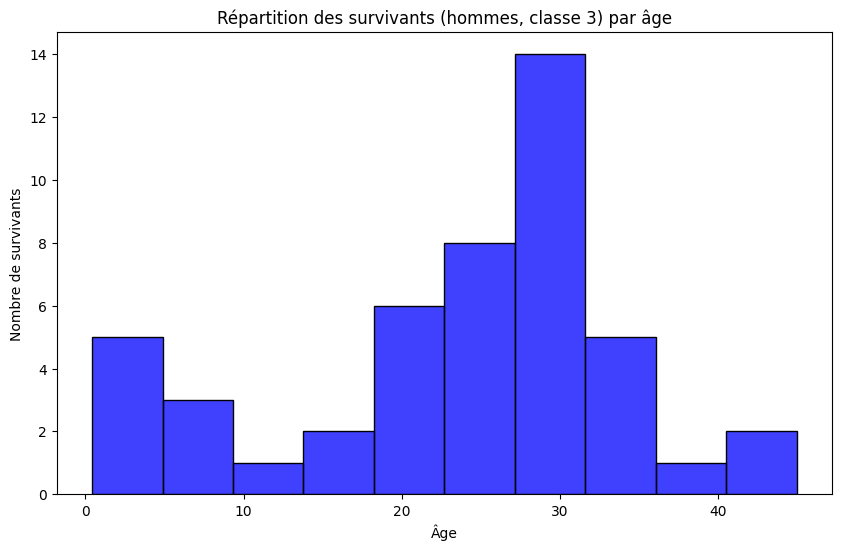

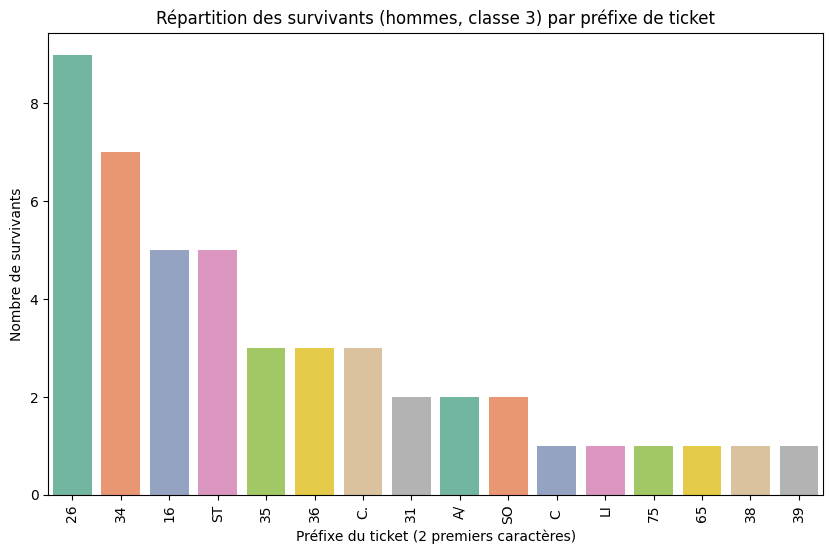

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrer les hommes de la classe 3 qui ont survécu
male_class3_survived = train_df[(train_df['Pclass'] == 3) & 
                                (train_df['Sex'] == 1) &  # 1 correspond à 'male'
                                (train_df['Survived'] == 1)]

# Créer une nouvelle colonne pour extraire les deux premiers caractères du ticket
male_class3_survived['Ticket_Prefix_2'] = male_class3_survived['Ticket'].astype(str).str[:2]

# Graphique 1 : Classer par âge
plt.figure(figsize=(10, 6))
sns.histplot(male_class3_survived['Age'].dropna(), kde=False, bins=10, color='blue')
plt.title('Répartition des survivants (hommes, classe 3) par âge')
plt.xlabel('Âge')
plt.ylabel('Nombre de survivants')
plt.show()

# Graphique 2 : Classer par préfixe de ticket
plt.figure(figsize=(10, 6))
sns.countplot(x='Ticket_Prefix_2', data=male_class3_survived, order=male_class3_survived['Ticket_Prefix_2'].value_counts().index, palette='Set2')
plt.title('Répartition des survivants (hommes, classe 3) par préfixe de ticket')
plt.xlabel('Préfixe du ticket (2 premiers caractères)')
plt.ylabel('Nombre de survivants')
plt.xticks(rotation=90)
plt.show()


In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# 1. Préparation des données
train_df['Ticket_Prefix'] = train_df['Ticket'].apply(lambda x: str(x)[:2])

# Taille de la famille
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

# Encodage du sexe et des préfixes de tickets
le_sex = LabelEncoder()
train_df['Sex'] = le_sex.fit_transform(train_df['Sex'])

le_ticket = LabelEncoder()
train_df['Ticket_Prefix'] = le_ticket.fit_transform(train_df['Ticket_Prefix'])

# Remplir les âges manquants avec la médiane
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

# 2. Sélection des caractéristiques
features = ['Pclass', 'Sex', 'Age', 'Ticket_Prefix', 'FamilySize']
X = train_df[features]
y = train_df['Survived']

# 3. Séparation des données en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Modèle XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 5. Optimisation des hyperparamètres avec GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 6. Résultats
best_model = grid_search.best_estimator_

# Faire des prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Afficher la précision et un rapport détaillé
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle optimisé : {accuracy * 100:.2f}%")

# Affichage du rapport de classification pour plus de détails
print(classification_report(y_test, y_pred))

# Affichage des meilleurs hyperparamètres
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")


/tmp/ipykernel_37/133626016.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].median(), inplace=True)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree

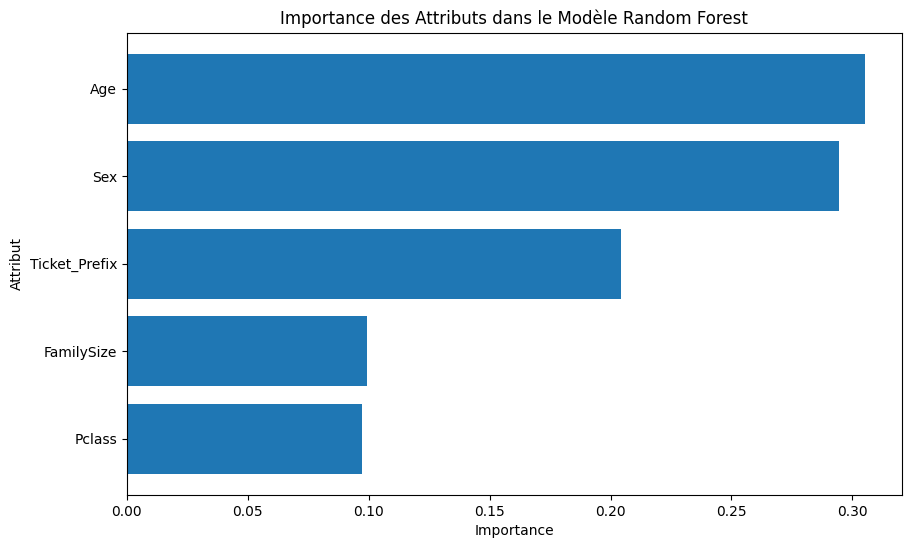

In [28]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Entraînement d'un modèle Random Forest (en supposant que tes données soient prêtes)
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)  # Remplace X_train et y_train par tes données

# Importance des variables
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Attribut')
plt.title('Importance des Attributs dans le Modèle Random Forest')
plt.gca().invert_yaxis()  # Inverser l'axe pour que les plus importantes soient en haut
plt.show()


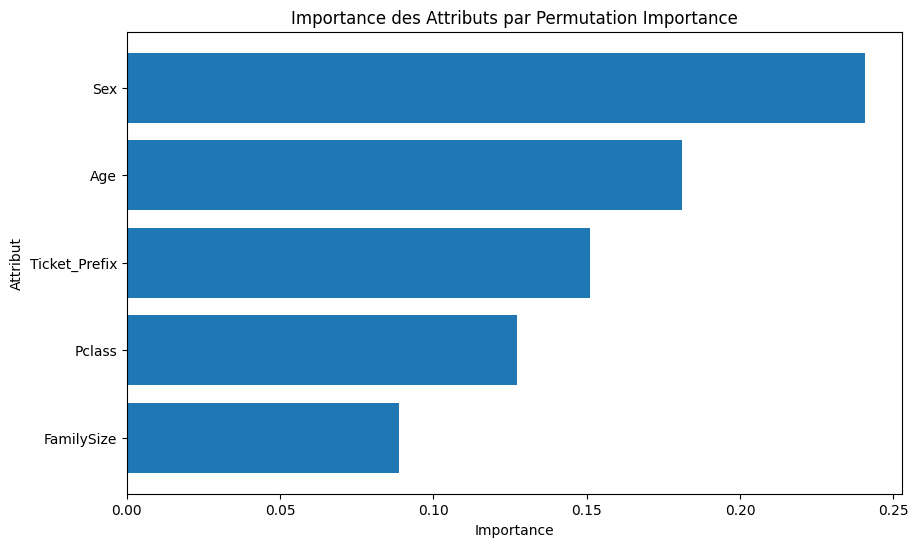

In [30]:
from sklearn.inspection import permutation_importance

# Calcul de l'importance par permutation
result = permutation_importance(rf_model, X_train, y_train, n_repeats=10, random_state=42)

# Extraire et visualiser les résultats
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualisation
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Attribut')
plt.title('Importance des Attributs par Permutation Importance')
plt.gca().invert_yaxis()
plt.show()


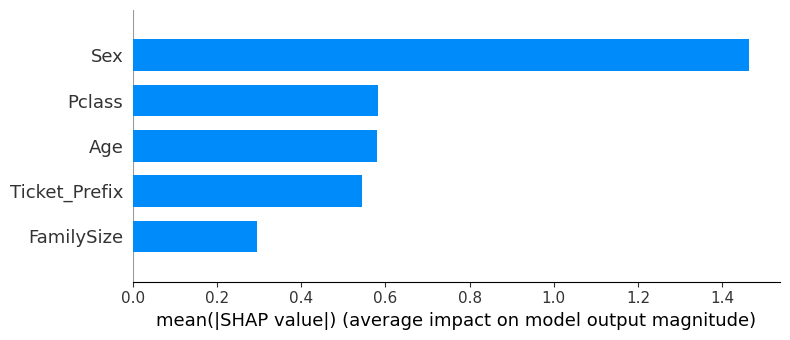

In [31]:
import shap

# Créer l'explainer SHAP pour XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Visualisation des SHAP values pour l'importance des variables
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [32]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Entraînement d'un modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Importance des variables
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Créer un DataFrame pour visualiser les importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage des résultats
print("Importance des Attributs (Random Forest):")
print(importance_df)


Importance des Attributs (Random Forest):
         Feature  Importance
2            Age    0.305153
1            Sex    0.294250
3  Ticket_Prefix    0.204367
4     FamilySize    0.099162
0         Pclass    0.097068


In [34]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Calcul de l'importance par permutation
result = permutation_importance(rf_model, X_train, y_train, n_repeats=10, random_state=42)

# Extraire et visualiser les résultats
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Affichage des résultats
print("Importance des Attributs (Permutation Importance):")
print(importance_df)


Importance des Attributs (Permutation Importance):
         Feature  Importance
1            Sex    0.240730
2            Age    0.181039
3  Ticket_Prefix    0.150983
0         Pclass    0.127247
4     FamilySize    0.088904


In [35]:
import shap
import pandas as pd

# Créer l'explainer SHAP pour XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Moyenne absolue des SHAP values pour chaque variable
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP Value': np.mean(np.abs(shap_values), axis=0)
})

# Trier par importance décroissante
shap_df = shap_df.sort_values(by='SHAP Value', ascending=False)

# Affichage des résultats
print("Importance des Attributs (SHAP Values):")
print(shap_df)


Importance des Attributs (SHAP Values):
         Feature  SHAP Value
1            Sex    1.464636
0         Pclass    0.581049
2            Age    0.580474
3  Ticket_Prefix    0.543407
4     FamilySize    0.294008


Précision du modèle XGBoost : 81.01%
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



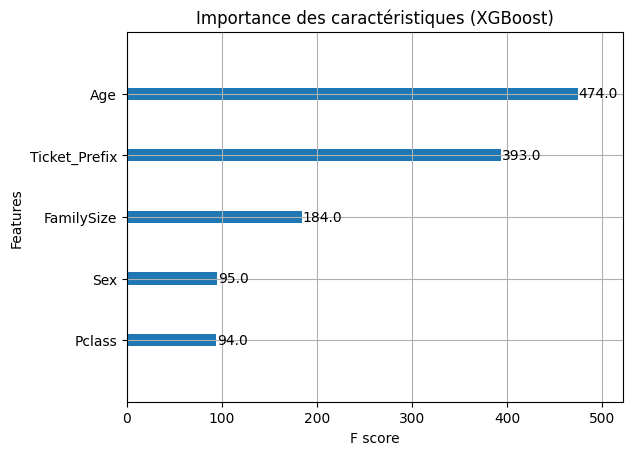

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Sélectionner les attributs les plus importants
features = ['Sex', 'Age', 'Pclass', 'Ticket_Prefix', 'FamilySize']

# Préparation des données (assurez-vous que train_df est bien nettoyé et prétraité)
X = train_df[features]
y = train_df['Survived']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir en DMatrix, le format optimisé pour XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Paramètres pour XGBoost basés sur les analyses précédentes
params = {
    'max_depth': 3,  # Profondeur optimale trouvée
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # Logarithmic loss
    'random_state': 42
}

# Entraîner le modèle XGBoost avec les paramètres
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred = xgb_model.predict(X_test)

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle XGBoost : {accuracy * 100:.2f}%")

# Rapport de classification détaillé
print(classification_report(y_test, y_pred))

# Importance des attributs
xgb.plot_importance(xgb_model)
plt.title('Importance des caractéristiques (XGBoost)')
plt.show()


In [38]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Préparation des données
features = ['Sex', 'Age', 'Pclass', 'Ticket_Prefix', 'FamilySize']

# Séparer les données pour les femmes et les hommes
X_females = train_df[train_df['Sex'] == 0][features]  # Femmes (Sex == 0)
y_females = train_df[train_df['Sex'] == 0]['Survived']

X_males = train_df[train_df['Sex'] == 1][features]  # Hommes (Sex == 1)
y_males = train_df[train_df['Sex'] == 1]['Survived']

# Diviser les ensembles en entraînement et test
X_train_females, X_test_females, y_train_females, y_test_females = train_test_split(X_females, y_females, test_size=0.2, random_state=42)
X_train_males, X_test_males, y_train_males, y_test_males = train_test_split(X_males, y_males, test_size=0.2, random_state=42)

# Paramètres de recherche
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Modèle XGBoost pour les femmes
xgb_model_females = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
grid_search_females = GridSearchCV(xgb_model_females, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_females.fit(X_train_females, y_train_females)

# Meilleurs hyperparamètres pour les femmes
print("Meilleurs hyperparamètres pour les femmes :")
print(grid_search_females.best_params_)

# Prédictions pour les femmes
y_pred_females = grid_search_females.predict(X_test_females)
accuracy_females = accuracy_score(y_test_females, y_pred_females)
print(f"Précision pour les femmes : {accuracy_females * 100:.2f}%")
print(classification_report(y_test_females, y_pred_females))

# Modèle XGBoost pour les hommes
xgb_model_males = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
grid_search_males = GridSearchCV(xgb_model_males, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_males.fit(X_train_males, y_train_males)

# Meilleurs hyperparamètres pour les hommes
print("Meilleurs hyperparamètres pour les hommes :")
print(grid_search_males.best_params_)

# Prédictions pour les hommes
y_pred_males = grid_search_males.predict(X_test_males)
accuracy_males = accuracy_score(y_test_males, y_pred_males)
print(f"Précision pour les hommes : {accuracy_males * 100:.2f}%")
print(classification_report(y_test_males, y_pred_males))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs hyperparamètres pour les femmes :
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Précision pour les femmes : 80.95%
              precision    recall  f1-score   support

           0       0.88      0.39      0.54        18
           1       0.80      0.98      0.88        45

    accuracy                           0.81        63
   macro avg       0.84      0.68      0.71        63
weighted avg       0.82      0.81      0.78        63

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs hyperparamètres pour les hommes :
{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Précision pour les hommes : 83.62%
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        96
           1       1.00      0.05      0.10        20

    accuracy     

In [45]:
# Filtrer les données pour les femmes
female_data = train_df[train_df['Sex'] == 1]  # 1 représente les hommes dans cette situation

# Regrouper par classe et calculer le taux de survie
survival_rate_by_class_female = female_data.groupby('Pclass').agg(
    num_females=('PassengerId', 'count'),
    survival_rate=('Survived', 'mean')
).reset_index()

# Afficher les résultats
print(survival_rate_by_class_female)

# Afficher le résultat sous forme de pourcentage
survival_rate_by_class_female['survival_rate'] = survival_rate_by_class_female['survival_rate'] * 100
print("\nTaux de survie des homme par classe (en %):")
print(survival_rate_by_class_female)


   Pclass  num_females  survival_rate
0       1          122       0.368852
1       2          108       0.157407
2       3          347       0.135447

Taux de survie des homme par classe (en %):
   Pclass  num_females  survival_rate
0       1          122      36.885246
1       2          108      15.740741
2       3          347      13.544669


In [44]:
# Filtrer les données pour les femmes
female_data = train_df[train_df['Sex'] == 0]  # 0 représente les femmes dans cette situation

# Regrouper par classe et calculer le taux de survie
survival_rate_by_class_female = female_data.groupby('Pclass').agg(
    num_females=('PassengerId', 'count'),
    survival_rate=('Survived', 'mean')
).reset_index()

# Afficher les résultats
print(survival_rate_by_class_female)

# Afficher le résultat sous forme de pourcentage
survival_rate_by_class_female['survival_rate'] = survival_rate_by_class_female['survival_rate'] * 100
print("\nTaux de survie des femmes par classe (en %):")
print(survival_rate_by_class_female)


   Pclass  num_females  survival_rate
0       1           94       0.968085
1       2           76       0.921053
2       3          144       0.500000

Taux de survie des femmes par classe (en %):
   Pclass  num_females  survival_rate
0       1           94      96.808511
1       2           76      92.105263
2       3          144      50.000000


In [46]:
# Filtrer les données pour les femmes (Sex == 0) décédées (Survived == 0) et en première ou deuxième classe (Pclass == 1 ou Pclass == 2)
femmes_decedees_1_2_classe = train_df[(train_df['Sex'] == 0) & (train_df['Survived'] == 0) & (train_df['Pclass'].isin([1, 2]))]

# Afficher toutes les informations des passagères
print(femmes_decedees_1_2_classe[['Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']])


                                                  Name  Pclass  Sex   Age  \
41   Turpin, Mrs. William John Robert (Dorothy Ann ...       2    0  27.0   
177                         Isham, Miss. Ann Elizabeth       1    0  50.0   
199             Yrois, Miss. Henriette ("Mrs Harbeck")       2    0  24.0   
297                       Allison, Miss. Helen Loraine       1    0   2.0   
312              Lahtinen, Mrs. William (Anna Sylfven)       2    0  26.0   
357                          Funk, Miss. Annie Clemmer       2    0  38.0   
498    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)       1    0  25.0   
772                                  Mack, Mrs. (Mary)       2    0  57.0   
854      Carter, Mrs. Ernest Courtenay (Lilian Hughes)       2    0  44.0   

     SibSp  Parch       Ticket      Fare    Cabin  Embarked  
41       1      0        11668   21.0000      NaN         2  
177      0      0     PC 17595   28.7125      C49         0  
199      0      0       248747   13.0000   

In [47]:
# Filtrer les données pour les femmes (Sex == 0) décédées (Survived == 0) et en première ou deuxième classe (Pclass == 1 ou Pclass == 2)
femmes_decedees_1_2_classe = train_df[(train_df['Sex'] == 0) & (train_df['Survived'] == 0) & (train_df['Pclass'].isin([1, 2]))]

# Afficher toutes les informations des passagères sous forme de tableau propre
import pandas as pd
pd.set_option('display.max_columns', None)  # pour afficher toutes les colonnes
pd.set_option('display.expand_frame_repr', False)  # pour éviter les coupures de ligne dans le tableau

# Afficher le tableau propre
femmes_decedees_1_2_classe[['Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]


,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
41,"Turpin, Mrs. William John Robert (Dorothy Ann ...",2,0,27.0,1,0,11668,21.0000,NaN,2
177,"Isham, Miss. Ann Elizabeth",1,0,50.0,0,0,PC 17595,28.7125,C49,0
199,"Yrois, Miss. Henriette (""Mrs Harbeck"")",2,0,24.0,0,0,248747,13.0000,NaN,2
297,"Allison, Miss. Helen Loraine",1,0,2.0,1,2,113781,151.5500,C22 C26,2
312,"Lahtinen, Mrs. William (Anna Sylfven)",2,0,26.0,1,1,250651,26.0000,NaN,2
357,"Funk, Miss. Annie Clemmer",2,0,38.0,0,0,237671,13.0000,NaN,2
498,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,0,25.0,1,2,113781,151.5500,C22 C26,2
772,"Mack, Mrs. (Mary)",2,0,57.0,0,0,S.O./P.P. 3,10.5000,E77,2
854,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",2,0,44.0,1,0,244252,26.0000,NaN,2


In [59]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

# Charger les données
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

# Fill missing values
train_df['Age'].fillna(train_df.groupby(['Pclass', 'Sex'])['Age'].transform('median'), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

# Feature Engineering
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = np.where(train_df['FamilySize'] == 1, 1, 0)

# Extract Titles from names
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

# Encoding categorical features
label_enc = LabelEncoder()
train_df['Sex'] = label_enc.fit_transform(train_df['Sex'])
train_df['Embarked'] = label_enc.fit_transform(train_df['Embarked'])
train_df['Title'] = label_enc.fit_transform(train_df['Title'])

# Drop irrelevant features
train_df = train_df.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)

# Define feature matrix X and target variable y
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
log_model = LogisticRegression(random_state=42)
svm_model = SVC(probability=True, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)

# Create an ensemble using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('log', log_model),
    ('svm', svm_model),
    ('knn', knn_model)
], voting='soft')

# Cross-validate the ensemble model
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5)
print(f"Ensemble model accuracy: {cv_scores.mean() * 100:.2f}%")

# Train and evaluate
ensemble_model.fit(X_train, y_train)
test_score = ensemble_model.score(X_test, y_test)
print(f"Test set accuracy: {test_score * 100:.2f}%")


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A valu

Ensemble model accuracy: 81.18%
Test set accuracy: 82.12%


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [60]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Perform GridSearchCV on the Random Forest model
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Check the best parameters
print("Best parameters found: ", grid_search_rf.best_params_)

# Use the best model found by GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

# Evaluate it
test_score_rf = best_rf_model.score(X_test, y_test)
print(f"Tuned Random Forest Test set accuracy: {test_score_rf * 100:.2f}%")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] E